In [72]:
from lagom.envs import make_vec_env
from lagom.envs import make_gym_env
from lagom.envs.vec_env import SerialVecEnv
from lagom.envs import EnvSpec

from lagom.runner import TrajectoryRunner

from model import Agent

config = {'network.hidden_size': [32]}

env = make_vec_env(vec_env_class=SerialVecEnv, 
                   make_env=make_gym_env, 
                   env_id='Pendulum-v0', 
                   num_env=5, 
                   init_seed=0, 
                   rolling=False)
env_spec = EnvSpec(env)

agent = Agent(config, env_spec, None)
runner = TrajectoryRunner(config, agent, env)
D = runner(200)


Policy
	EnvSpec: <EnvSpec, <SerialVecEnv: Pendulum-v0, n: 5>>
	Number of environments: 5
	Observation space: Box(3,)
	Action space: Box(1,)
	Control type: Continuous
	T: 200
	Max episode reward: None
	Reward range: (-inf, inf)
	Is VecEnv: True
	Recurrent: False

In [79]:
agent.policy.feature_network

MLP(
  (feature_layers): ModuleList(
    (0): Linear(in_features=3, out_features=32, bias=True)
  )
)

In [39]:
from lagom.envs import make_vec_env
from lagom.envs import make_gym_env
from lagom.envs.vec_env import SerialVecEnv
from lagom.envs import EnvSpec

env = make_vec_env(SerialVecEnv, make_gym_env, 'Pendulum-v0', 3, 0, False)
env_spec = EnvSpec(env)
env_spec.observation_space.low

array([-1., -1., -8.], dtype=float32)

In [24]:
agent = Agent({'network.hidden_size': [10]}, env_spec, None)

In [ ]:
   
class LSTM(BaseRNN):
    def make_params(self, config):
        self.rnn = nn.LSTMCell(input_size=self.env_spec.observation_space.flat_dim, 
                               hidden_size=config['network.hidden_size'][0])

        self.last_feature_dim = config['network.hidden_size'][0]
        
    def init_params(self, config):
        ortho_init(self.rnn, nonlinearity=None, weight_scale=1.0, constant_bias=0.0)
        
    def init_hidden_states(self, config, batch_size, **kwargs):
        h = torch.zeros(batch_size, config['network.hidden_size'][0])
        h = h.to(self.device)
        c = torch.zeros_like(h)

        return [h, c]
    
    def rnn_forward(self, x, hidden_states, mask=None, **kwargs):
        # mask out hidden states if required
        if mask is not None:
            h, c = hidden_states
            mask = mask.to(self.device)
            
            h = h*mask
            c = c*mask
            hidden_states = [h, c]

        h, c = self.rnn(x, hidden_states)

        out = {'output': h, 'hidden_states': [h, c]}

        return out
    



In [49]:
from pathlib import Path

import numpy as np

from lagom.experiment import Configurator

from lagom.utils import pickle_load

from lagom.vis import CurvePlot

In [50]:
log_folder = Path('logs')

list_config = pickle_load(log_folder/'configs.pkl')
configs = Configurator.to_dataframe(list_config)
configs

,ID,cuda,env.id,env.standardize,network.recurrent,network.hidden_size,es.algo,es.popsize,es.mu0,es.std0,train.num_iteration,train.N,log.print_interval,log.dir
0,0,False,Pendulum-v0,True,False,[32],OpenAIES,16,0.0,0.5,1000,5,100,logs


In [51]:
def load_results(log_folder, ID):
    p = Path(log_folder)/str(ID)
    
    list_result = []
    for sub in p.iterdir():
        if sub.is_dir() and (sub/'result.pkl').exists():  # seed directories
            list_result.append(pickle_load(sub/'result.pkl'))
            
    return list_result


def get_returns(list_result):
    returns = []
    for result in list_result:
        returns.append(result['best_return'])
        
    return returns

In [52]:
list_result = load_results('logs/', 0)
returns = get_returns(list_result)
returns = np.asarray(returns)[:, ::10]

env_id = configs.iloc[0]['env.id']

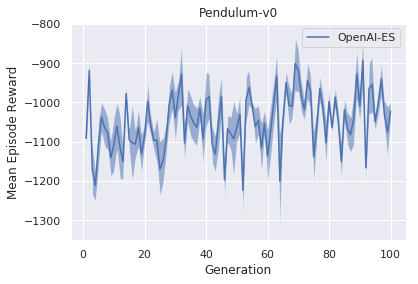

In [53]:
plot = CurvePlot()
plot.add('OpenAI-ES', returns)
ax = plot(title=env_id, 
          xlabel='Generation', 
          ylabel='Mean Episode Reward', 
          num_tick=6, 
          xscale_magnitude=None)

In [33]:
ax.figure.savefig(f'data/{env_id}.png')